# Generate Training Space

For now, we will take the $R$-matrix parameter posteriors from a previous run to define training distributions. In the future, we would like to use AZURE2's bset fit and error estimates. Unfortunately, we want to sample ANCs. The best fit when ANCs are varied is pretty bad.

In [3]:
import os
import sys
import pickle
from multiprocessing import Pool

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import emcee

import model
import priors

sys.path.append('/home/odell/7Be')
import run


os.environ['OMP_NUM_THREADS'] = '1'

In [4]:
nbr = model.branching_ratio.shape[0]
ncap = model.num_pts_total_capture
nscat = model.num_pts_total_scatter

In [31]:
def ln_prior(theta):
    return np.sum([p.logpdf(t) for (p, t) in zip(priors.priors, theta)])

def ln_likelihood(theta):
    theta_R = theta[:model.nrpar]
    theta_f_capture = theta[model.nrpar:model.nrpar+model.nf_capture]
    theta_f_scatter = theta[model.nrpar+model.nf_capture:]

    f_capture = model.map_uncertainty(theta_f_capture, model.num_pts_capture)
    f_scatter = model.map_uncertainty(theta_f_scatter, model.num_pts_scatter)

    f = np.ones(nbr+ncap+nscat)
    f[nbr:nbr+ncap] = f_capture
    f[nbr+ncap:] = f_scatter

    mu= model.calculate(theta_R)
    return np.sum(-np.log(np.sqrt(2*np.pi*model.dy)) - 0.5*(f*model.y - mu)**2/(f*model.dy)**2)


def ln_posterior(theta):
    lnpi = ln_prior(theta)
    if lnpi == -np.inf:
        return -np.inf
    return lnpi + ln_likelihood(theta)

In [32]:
nw = 2*model.ndim
theta_star = np.load('datfiles/theta_star.npy')[:-1]

In [35]:
p0 = np.array(
    [stats.norm(theta_star, 0.01*np.abs(theta_star)).rvs() for _ in range(nw)]
)
moves = [(emcee.moves.DEMove(), 0.2), (emcee.moves.DESnookerMove(), 0.8)]

pool = Pool(processes=16)
sampler = emcee.EnsembleSampler(nw, model.ndim, ln_posterior, moves=moves, pool=pool)

In [36]:
state = sampler.run_mcmc(p0, 500, thin_by=10, tune=True, progress=True)

100%|██████████| 5000/5000 [15:24<00:00,  5.41it/s]


In [37]:
chain = sampler.get_chain()

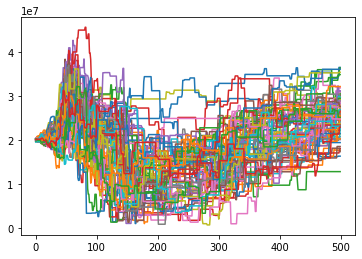

In [45]:
plt.plot(chain[:, :, 2]);